By James Liu
$$\\$$
In this notebook I will analyze Dixit from a game-theoretic perspective. You might be wondering why I decided to do this for a party game, but it is precisely the fact that Dixit is a party game that it is simple enough to solve using analytical techniques. The applicability of this analysis to real gameplay is somewhat neutralized by the fact that using inside jokes whenever possible is likely the best way to win. Also, it's a party game.

# Dixit, Formally

All players are assumed to be rational and there is no shared information or collusion among a subset of players.
The artwork is pretty sweet but game-theoretically irrelevant. Instead we consider cards to be random numbers drawn uniformly from the real interval $I=[0,1]$. The number of players will be $n+1$ such that there are $n$ non-host players.

The round starts when the host announces some sort of clue, which for now can be formalized by announcing some subset of $I$, with measure ("length") $m$ . Then each player, including the host, submits a card, simultaneously.

The host is incentivized to have chosen a clue which matches the card that they submit. The players are also incentivized to submit a card matching the clue if they have one. This, of course, matches the common-sense understanding of how to play Dixit properly.

Also, the host should choose the clue in such a way so that no card matching the clue is more likely to be the host's card than the other. There is an extension that allows for the host to give such "non-uniform clues", which I'll save for later. For fixed $h$, here is a naive scheme for choosing the clue:

> Let the host card be $c$.

> If $c+m<1$ then announce $[c,c+m]$. Otherwise, announce $[1-m,1]$.

This is an artificially poor scheme, since it will be often obvious to the players that the host's card is the one that lies at the start of the interval. Instead,

> Let $r \sim uniform(m)$ and $s=c-r$.

> Announce the interval $[s,s+m]$. If $s<0$, instead announce $[0,s+m] \cup [1+s,1]$ and likewise for $s+m>1$.

In other words, we just wrap around if the subset exceeds the boundary. This ensures that $c$ is uniformly distributed in relation to the announced interval.

Now, a player has at least one matching card with probability $p=1-(1-m)^h$, where $h$ is the hand size.

The number of matching cards is given by $k+1$ where $k \sim binomial(n,p)$

Now, each non-host player guesses simultaneously. The number of correct guesses is $g \sim binomial(k,\frac{1}{k}) + binomial(n-k,\frac{1}{k+1})$ since the $k$ players who submitted a matching card won't/can't guess their own card.

The rules for points are:
- If all players guess correctly or all players guess wrong, they all get 2 points, while the host gets 0 points.
- Otherwise, the players who guess correctly get 3 points, and the host gets 3 points.
- In all cases, any non-host player whose submitted card is guessed gets 1 point per guess.

Using the principle of symmetry, the host values 1 point for an opponent at $-\frac{1}{n}$ such that all players getting 1 point is valued at 0. This is equivalent to saying the player wants to maximize their score relative to the average.

We can now specify the payoff function for the host:

$$ \begin{cases}
    -3, & \text{if}\ g=0 \\
    -2, & \text{if}\ g=n \\
    2-\frac{2g}{n}, & \text{otherwise}
\end{cases} $$

The last line is a simplification of $3-\frac{n-g}{n}-\frac{3g}{n}$.

# Optimal Strategy

Here is a graph of the average value for a fixed number of players and matching submissions.

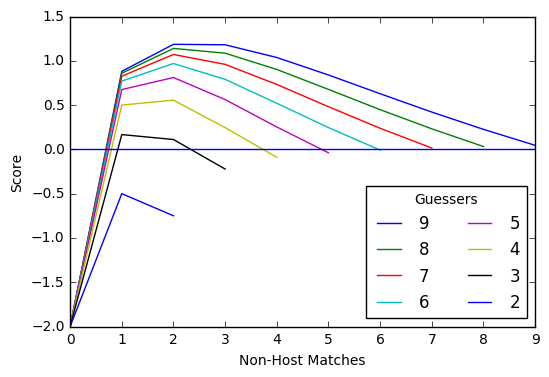

In [17]:
import scipy.stats as st
import scipy.optimize as opt
from scipy import integrate
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


def binomialDistVector(n,p):
	b=st.binom(n,p)
	return np.array([b.pmf(i) for i in range(n+1)])

def success(dist):
	return 1-dist[0]-dist[-1]

def utility(dist):
	n=len(dist)-1
	payoff=[-3]+[2-2.0*c/n for c in range(1,n)]+[-2]
	return (dist*payoff).sum()
	
def guessDistribution(n,k):
	if k==0:
		return np.array([0]*n+[1])
	valid=binomialDistVector(k,1.0/k) #distribution of correct guesses among players with valid submissions
	invalid=binomialDistVector(n-k,1.0/(k+1)) # didn't submit valid card
	return np.convolve(valid,invalid)


for n in reversed(range(2,10)):
    plt.plot([utility(guessDistribution(n,k)) for k in range(n+1)],label="%u"%n)
plt.legend(title="Guessers",loc=4,ncol=2)
plt.xlabel("Non-Host Matches")
plt.ylabel("Score")
plt.axhline()
plt.show()

The maximum number of guessers in real-life Dixit is only 5, but I've displayed some extra curves because it looks nicer.
There are a few things to conclude from the graph:
- It's good to be the host in larger games, but not for smaller games
- The ideal number of matches is quite low, 1 or 2.
- The penalty for giving too strong a clue is much harsher than giving too weak a clue.

Here's a similar graph which shows the probability of a good outcome for the host:

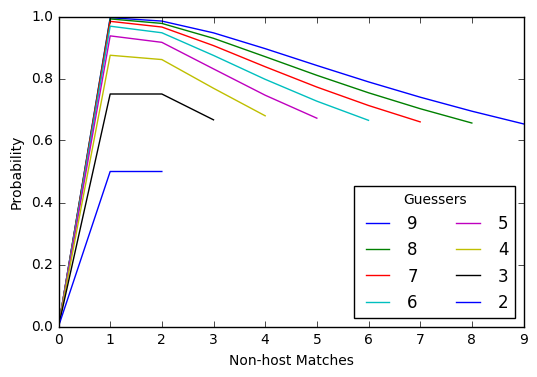

In [42]:
for n in reversed(range(2,10)):
    plt.plot([success(guessDistribution(n,k)) for k in range(n+1)],label="%u"%n)
plt.legend(title="Guessers",loc=4,ncol=2)
plt.xlabel("Non-host Matches")
plt.ylabel("Probability")
plt.show()

We can see that denying points for correct guessers is a fairly low priority, as the shape of the curves is only a little changed.

Now to optimize $p$:

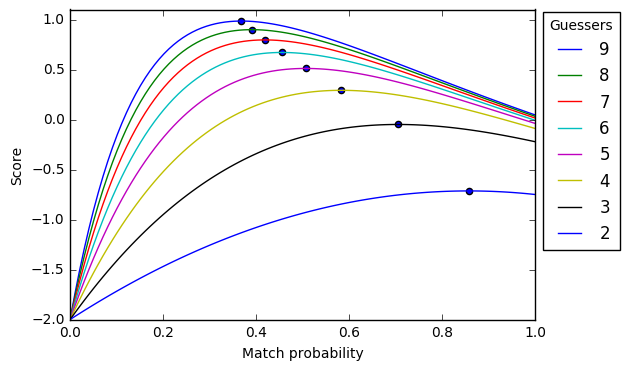

Score at optimal p:
2 guessers: -0.714285714286
3 guessers: -0.0496615162433
4 guessers: 0.291805169487
5 guessers: 0.510556385171
6 guessers: 0.670357778095
7 guessers: 0.795857315474
8 guessers: 0.898491215852
9 guessers: 0.984515233087

Average non-host matches at optimal p:
2 guessers: 1.71428571429
3 guessers: 2.11459882196
4 guessers: 2.3316930637
5 guessers: 2.53225939571
6 guessers: 2.73188218628
7 guessers: 2.9297294493
8 guessers: 3.12413627348
9 guessers: 3.31442930347


In [65]:
def payoffFunction(n):
    payoffs=np.array([utility(guessDistribution(n,i)) for i in range(0,n+1)])
    return lambda p: (payoffs*binomialDistVector(n,p)).sum()

def dixitOptimizer(n):
    fun=payoffFunction(n)
    optfun=lambda p: -fun(p)
    res=opt.minimize_scalar(optfun,bounds=(0,1),method="Bounded")
    return res.x if res.x<.999 else 1,-res.fun

X=np.linspace(0,1,100)
for n in reversed(range(2,10)):
    plt.plot(X,np.vectorize(payoffFunction(n))(X),label="%u"%n)
    plt.scatter(*dixitOptimizer(n))
    
plt.xlabel("Match probability")
plt.ylabel("Score")
plt.xlim([0,1])
plt.ylim([-2,1.1])
plt.legend(title="Guessers",bbox_to_anchor=(1.2,1.02))
plt.show()

print("Score at optimal p:")
for n in range(2,10):
    print("{} guessers: {}".format(n,dixitOptimizer(n)[1]))


print("\nAverage non-host matches at optimal p:")
for n in range(2,10):
    print("{} guessers: {}".format(n,n*dixitOptimizer(n)[0]))


This is not surprising. While 1 or 2 matches are optimal, it's better to err on the higher side.

Finally, the optimal probability for a single card is $m=1-\sqrt[h]{1-p}$.

I still need to show that there aren't better strategies of a different form. But first, I'll discuss how the analysis translates to human gameplay.

# Sensitivity Analysis


A rational player will be able to consistently set $m$ exactly, making hand size irrelevant. A human playing Dixit will have a hard time announcing a subset with measure close to $m$ using human-understandable clues. This is especially true when the hand size is large, since small changes in $m$ will cause large changes in $p$.

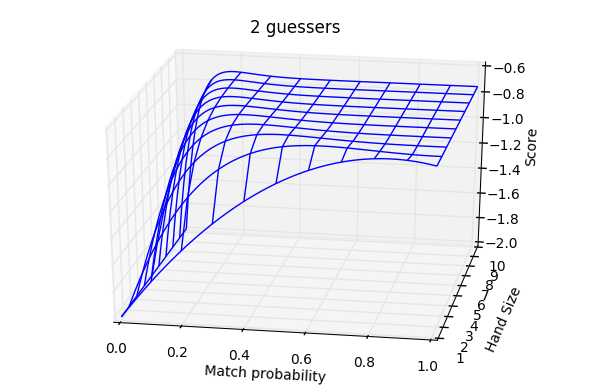

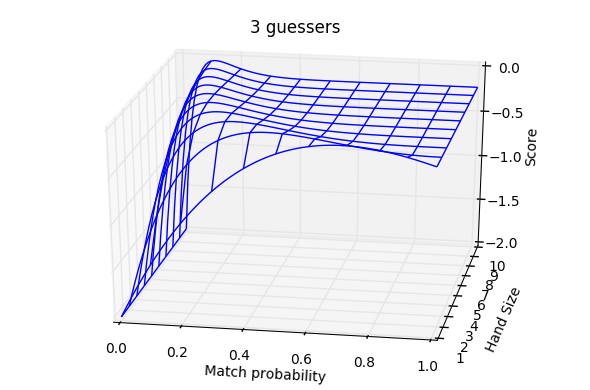

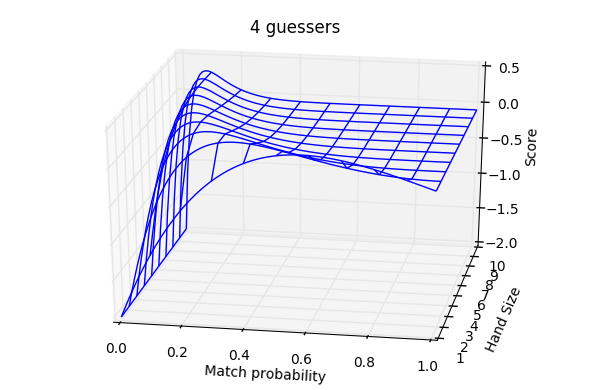

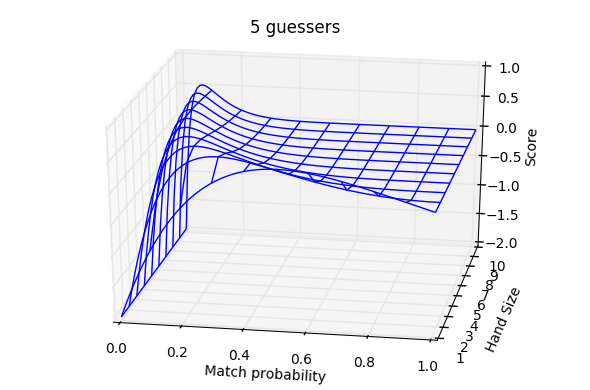

In [24]:
def matchProbability(m,h): 
	return 1-(1-m)**h


X,Y=np.meshgrid(np.linspace(0,1,100),range(1,11))
for n in range(2,6):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fun=payoffFunction(n)
    Z=np.vectorize(lambda m,h: fun(matchProbability(m,h)))(X,Y)

    ax.plot_wireframe(X, Y, Z, rstride=1, cstride=10)
    plt.title("%u guessers"%n)
    plt.xlabel("Match probability")
    plt.ylabel("Hand Size")
    ax.set_zlabel("Score")
    ax.view_init(25,280)
    fig.tight_layout()
    plt.show()

To model uncertainty in $m$, we can assume that the host announces $$m=logistic(n)=\frac{1}{1+e^{-n}},\space n \sim normal(\mu,\sigma^2)$$ 

Not surprisingly, this is referred to as the logistic normal distribution.

Here's some density functions for various choices of $\mu$ and $\sigma$.


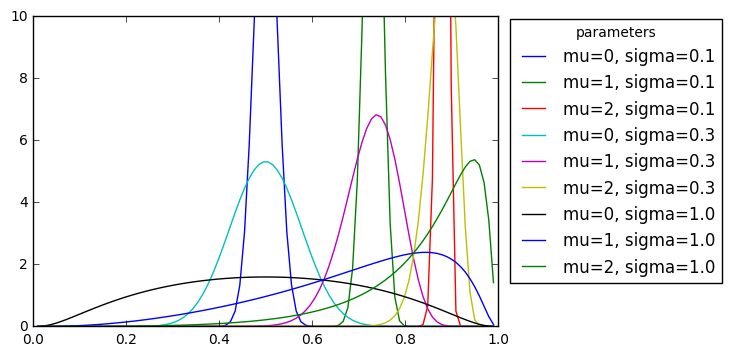

In [84]:
def logit(p):
    return np.log(p/(1-p))

def logistic(x):
    return 1/(1+np.exp(-x))

def logitnormpdf(mu,sigma):
    normal=st.norm(mu,sigma)
    return lambda x: normal.pdf(logit(x))/x/(1-x)


X=np.linspace(0,1,100)[1:-1]
for s in [.1,.3,1]:
    for u in [0,1,2]:
        pdf=logitnormpdf(u,s)
        plt.plot(X,[pdf(x) for x in X],label="mu=%u, sigma=%.1f"%(u,s))
plt.ylim([0,10])
#plt.yscale("log")
plt.legend(title="parameters",bbox_to_anchor=(1.5,1.02))
#plt.xlabel("Non-Host Matches")
#plt.ylabel("Score")
#plt.axhline()
plt.show()

My intuition is that $\sigma \in [.1,.3]$ should be an appropriate choice.


Now, in the model host selects $\mu$ with $\sigma$ fixed. Lower $\sigma$ represents the skill of the player in being able to consistently choose clues that are just narrow enough. The optimal $\mu$ will be negatively correlated with $\sigma$; lesser skilled players should be err on the safe side of giving broader clues.

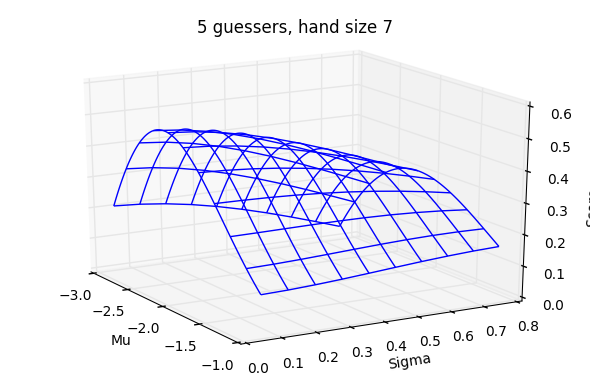

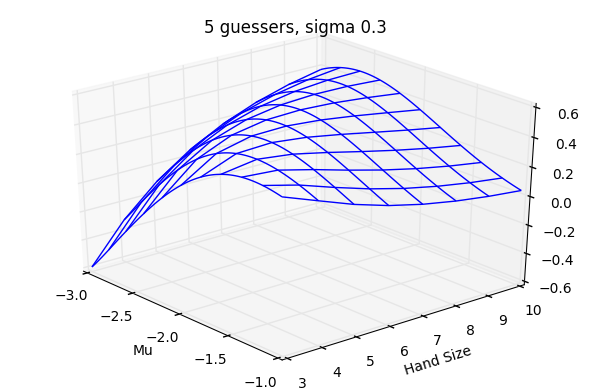

Score at optimal mu
3 cards: 0.473
4 cards: 0.471
5 cards: 0.469
6 cards: 0.468
7 cards: 0.468
8 cards: 0.467
9 cards: 0.467
10 cards: 0.466


In [85]:

def integrateUtilityOverPDF(n,h,samples=1000):
    M=np.linspace(0,1,samples)[1:-1]
    values=np.vectorize(payoffFunction(n))(matchProbability(M,h))
    def helper(pdf):
        ys=pdf(M)*values
        return integrate.simps(ys,M,axis=0,even='first')
    return helper


X,Y=np.meshgrid(np.linspace(-3,-1,100),np.linspace(.05,.75,10))
for n in [5]:
    for h in [7]:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        fun=integrateUtilityOverPDF(n,h)
        Z=np.vectorize(lambda mu,sigma: fun(logitnormpdf(mu,sigma)))(X,Y)

        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=10)
        plt.title("%u guessers, hand size %u"%(n,h))
        plt.xlabel("Mu")
        plt.ylabel("Sigma")
        ax.set_zlabel("Score")
        ax.view_init(20,-30)
        fig.tight_layout()
        plt.show()

H=np.arange(3,11)
X,Y=np.meshgrid(np.linspace(-3,-1,100),H)
#medianX,Y=np.meshgrid(logistic(np.linspace(-3,-1,100)),H)
for n in [5]:
    for sigma in [.3]:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        funs=dict([(h,integrateUtilityOverPDF(n,h,samples=100)) for h in H])
        
        Z=np.vectorize(lambda mu,h:funs[h](logitnormpdf(mu,sigma)))(X,Y)
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=10)
        #ax.plot_wireframe(medianX, Y, Z, rstride=1, cstride=10)
        plt.title("%u guessers, sigma %.1f"%(n,sigma))
        plt.xlabel("Mu")
        plt.ylabel("Hand Size")
        ax.set_zlabel("Score")
        ax.view_init(30,-40)
        fig.tight_layout()
        plt.show()
        print("Score at optimal mu")
        for pair in zip(H,Z.max(axis=1)):
            print "%u cards: %.3f"%pair

The hand size actually has quite a weak effect on score.

# Non-Uniform Strategies

In the previous scheme, any matching card is equally likely to be the host's card. It's possible to develop a strategy where this isn't the case.

Since it turns out that using non-uniform strategies offers no advantage over a uniform strategy, I'll merely find an upper-bound for them. It should also be intuitively clear that it's counterproductive to create excess public information; it causes player guesses to be correlated, which in turn increases the probability of the extremes of all players guessing right or wrong.

Let $H: I\rightarrow \mathbb{R}$ or $H: I\rightarrow \mathbb{N}$ be a hash function announced by the host. It is chosen randomly such that for each non-host card $x$, $H(x) \sim G$ where $G$ is a continuous distribution with pdf $g$ or discrete distribution with pmf $g$, respectively. Of course the $H(x)$ should be independent. Also, $H(c) \sim F$ with pdf/pmf $f$. The previous scheme reduces to cases where $\frac{f(x)}{g(x)}$ is a constant.


First, the hand size should be restricted to 1. This allows the host to fully control the distribution of submitted cards, which is just $G$. Observe that guessers will choose the card with the highest value of $\frac{f(x)}{g(x)}$. Without loss of generality we can assume this ratio is strictly decreasing in $x$ and so guessers will simply choose the card with the lowest hash.

Now, we want to find the value of $\max_{f, g} E[Score(f,g)] \leq \max_{f,g,v} E[Score(f,g)|H(c)=v]$. This latter quantity corresponds to the situation where the host is able to announce $f,g$ and then cheat by setting $H(c)=v$ without the players catching on, even after an infinite number of games.

With fixed $v$, there are only two interesting probabilities: $a=Pr(H(x)<v)$ and $b=Pr(H(x)=v)$. Any card with a higher hash will never be guessed. Also, note that if $a=0$ this reduces to the uniform case.

Now, the relevant distribution is $trinomial(n,a,b)$ with $k,l$ indicating respectively the number of cards with hashes that are less than, or equal to v. Conditioning on $k$:

>$k=0$: Reduces to uniform case. 

>$k=1$: All but one guessers will guess wrong. The last guesser will guess right with probability $\frac{1}{l}$.

>$k>=2$: All guessers will guess wrong.

Once again, here's graphs with scores for various values of $n,p,q$, where $p=a$ and $q=\frac{b}{1-a}$.

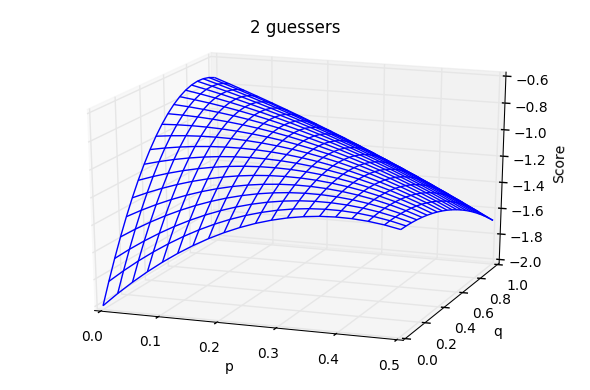

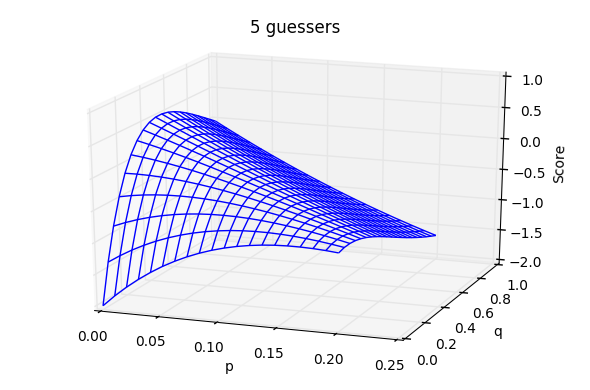

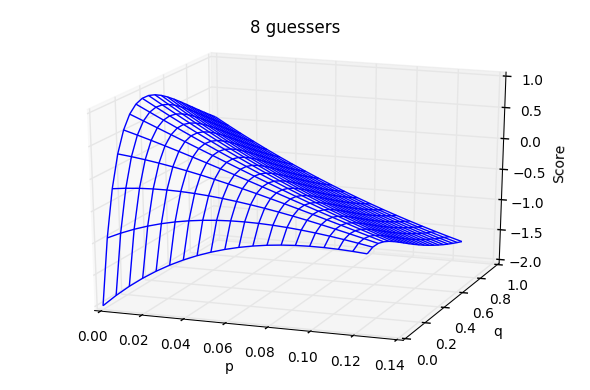

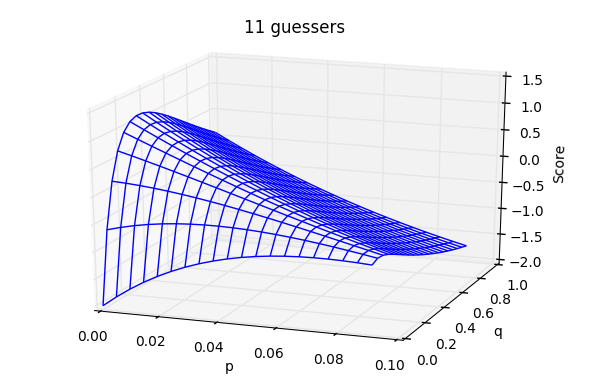

In [78]:
def secondPlaceFunction(n):
    payoffs=np.array([(5-2.0/n)/(k+1)-3 for k in range(n+1)])
    return lambda p: (payoffs*binomialDistVector(n,p)).sum()

def abFunction(n):
	zeroPayoff=payoffFunction(n)
	onePayoff=secondPlaceFunction(n-1)
	def helper(p,q):
		payoffs=np.array([zeroPayoff(q),onePayoff(q)]+[-3]*(n-1))
		return (payoffs*binomialDistVector(n,p)).sum()
	return helper


for n in range(2,14,3):
    X,Y=np.meshgrid(np.linspace(0,1.0/n,20),np.linspace(0,1,20))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    Z=np.vectorize(abFunction(n))(X,Y)
    ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
    plt.title("%u guessers"%n)
    plt.xlabel("p")
    plt.ylabel("q")
    #~ ax.set_zlim([0,1])
    ax.set_zlabel("Score")
    ax.view_init(20,-70)
    fig.tight_layout()
    plt.show()


It's a little tedious to prove for all $n$ that the maximum occurs with $p=0$, but the graphs should be fairly convincing.

In terms of real world gameplay, this suggests that clues that are rather mundane but rare are more effective in getting points, rather than a very narratively satisfying clue that induces a strict ordering in how well cards match it.

# Other potentially interesting analyses

- In games with less than 6 players, a house rule uses random submissions from the top of the deck. In this scenario, hand-size is no longer abstractable when considering optimal gameplay.

- Players often forget to draw cards. How much of a disadvantage is it to play with 1 or 2 less cards in hand?

- How might the host use other cards in their hand, or in the discard pile, to estimate the probability that cards will have a certain feature? 